In [1]:
import sys
from pathlib import Path

repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# IT Service Ticket Classification

## Navegação dos notebooks

- `notebooks/analysis.ipynb`: análise exploratória (EDA).
- `notebooks/classificators.ipynb`: testes de classificadores (TF-IDF, embeddings, RAG) com métricas no conjunto de teste.
- `notebooks/main.ipynb`: visão geral, prompts, pipeline, avaliação final (usa o classificador escolhido).


## 1. Carregamento e Preparação dos Dados

### Divisão em treino, teste e validação

Usamos três conjuntos de dados:

1. **Validação (balanceada)**: `VALIDATION_SIZE` tickets, com o mesmo número de exemplos por classe.
2. **Treino/Teste**: o restante é dividido em **80% treino** e **20% teste**, com estratificação.

**Por que assim?**
- **Validação balanceada** garante comparação justa entre classes.
- **Teste separado** permite comparar métodos antes da avaliação final.
- **Treino maior** melhora a qualidade dos modelos.


In [2]:
from classifier.data import load_dataset, train_test_validation_split

# Carregar dataset
df, classes = load_dataset()
print(f"Total de tickets: {len(df):,}")
df.head()

Total de tickets: 47,837


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [3]:
# Classes obtidas do dataset
print(f"Classes ({len(classes)}):")
for c in classes:
    print(f"  - {c}")

Classes (8):
  - Access
  - Administrative rights
  - HR Support
  - Hardware
  - Internal Project
  - Miscellaneous
  - Purchase
  - Storage


In [4]:
from classifier.config import VALIDATION_SIZE

# Split: validação balanceada + treino/teste estratificados (80/20)
train_df, test_df, validation_df = train_test_validation_split(
    df,
    validation_size=VALIDATION_SIZE,
)

print(f"Treino:     {len(train_df):,} tickets")
print(f"Teste:      {len(test_df):,} tickets")
print(f"Validação:  {len(validation_df):,} tickets")
print("\nDistribuição na validação:")
print(validation_df["Topic_group"].value_counts().sort_index())

Treino:     38,109 tickets
Teste:      9,528 tickets
Validação:  200 tickets

Distribuição na validação:
Topic_group
Access                   25
Administrative rights    25
HR Support               25
Hardware                 25
Internal Project         25
Miscellaneous            25
Purchase                 25
Storage                  25
Name: count, dtype: int64


## 2. Métodos de Classificação e Comparação

Os experimentos de classificação estão em `notebooks/classificators.ipynb`, onde rodamos TF-IDF, embeddings e RAG no conjunto de teste.

Modelo selecionado (teste):
- **TF-IDF (word-only) + LinearSVC** — accuracy **0.8623**, F1 macro **0.8634**, F1 weighted **0.8626**.

As seções seguintes assumem este modelo como escolhido.

Como o dataset é limpo, desativamos char n-grams e usamos apenas word n-grams.


## 3. Geração da Justificativa

Implementamos **dois métodos** de geração de justificativa para a classe predita:

### 3.1 Justificativa Linear (padrão)

- Usa os **pesos do classificador linear** (TF-IDF + LinearSVC) para selecionar os 2–4 word n-grams com maior contribuição para a classe predita.
- É **determinística**, rápida e não depende de LLM (ideal para execução local e reprodutível).
- Compartilha o **mesmo extrator de features TF-IDF** usado no treinamento do classificador, garantindo consistência entre decisão e justificativa.

In [5]:
from classifier.classifiers import TfidfClassifier
from classifier.config import RANDOM_STATE

# Treinar classificador base para exemplos de justificativa
ml_classifier = TfidfClassifier.linear_svc(random_state=RANDOM_STATE)
ml_classifier.fit(train_df)
features = ml_classifier.features

# Selecionar alguns tickets da validação como exemplos (reprodutível)
sample_tickets = validation_df.sample(3, random_state=RANDOM_STATE).reset_index(drop=True)

# Usamos o primeiro como "query" para os exemplos de prompts abaixo
sample = sample_tickets.iloc[0]
query = sample["Document"]
true_class = sample["Topic_group"]
predicted_class = ml_classifier.predict([query])[0]

In [6]:
from classifier.justifiers import LinearJustifier

linear_justifier = LinearJustifier(
    ml_classifier.classifier.coef_,
    ml_classifier.classifier.classes_,
    features,
)

print("=== EXEMPLOS (JUSTIFICATIVA LINEAR) ===")
for i, row in sample_tickets.iterrows():
    ticket = row["Document"]
    true = row["Topic_group"]
    pred = ml_classifier.predict([ticket])[0]
    details = linear_justifier.justify(ticket=ticket, predicted_class=pred)

    print(f"\n--- Ticket {i+1} ---")
    print(f"Classe real: {true}")
    print(f"Classe predita (ML): {pred}")
    print(f"Justificativa (linear): {details.result.justificativa}")
    print(f"Termos de evidência: {details.evidence_terms}")

=== EXEMPLOS (JUSTIFICATIVA LINEAR) ===

--- Ticket 1 ---
Classe real: HR Support
Classe predita (ML): HR Support
Justificativa (linear): O ticket foi classificado como 'HR Support' por mencionar 'leave', 'annual', 'annual leave', 'holiday', que são termos comumente associados a essa categoria.
Termos de evidência: ['leave', 'annual', 'annual leave', 'holiday']

--- Ticket 2 ---
Classe real: Miscellaneous
Classe predita (ML): Miscellaneous
Justificativa (linear): O ticket foi classificado como 'Miscellaneous' por mencionar 'add', 'add to', 'please add', 'to july', que são termos comumente associados a essa categoria.
Termos de evidência: ['add', 'add to', 'please add', 'to july']

--- Ticket 3 ---
Classe real: Administrative rights
Classe predita (ML): Administrative rights
Justificativa (linear): O ticket foi classificado como 'Administrative rights' por mencionar 'outlook', 'outlook issue', 'issues', 'she received', que são termos comumente associados a essa categoria.
Termos de evid

### 3.2 Justificativa com LLM + RAG

Quando queremos uma justificativa mais “natural”, usamos uma LLM para redigir 1–3 frases, condicionada à classe predita e a exemplos recuperados via RAG.

#### 3.2.1 Design dos Prompts

O prompt é dividido em duas partes:

1. **System prompt:** define o papel da LLM (gerar justificativas) e o formato de saída em JSON.
2. **User prompt:** inclui o ticket, a **classe atribuída** (saída do ML) e os **tickets similares** recuperados pelo RAG como evidência.

**Por que usar RAG aqui?**
- A LLM não decide a classe; ela só explica uma decisão já tomada.
- Tickets similares fornecem evidência (“casos parecidos na mesma classe”), fortalecendo a justificativa.

**Trade-off do número de similares (K):**
- **Mais similares:** justificativas mais ricas, porém maior custo em tokens.
- **Menos similares:** justificativas mais baratas, porém com menos evidência.


In [7]:
from classifier.llm import build_system_prompt, build_user_prompt
from classifier.rag import TicketRetriever

from classifier.config import EMBEDDING_MODEL, K_SIMILAR


# Indexar dados de treino para recuperar tickets similares (RAG)
retriever = TicketRetriever(EMBEDDING_MODEL)
retriever.index(train_df)

# Para comparação de tokens, buscamos um K maior
max_k = max(K_SIMILAR, 10)
similar = retriever.retrieve(query, k=max_k)

Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

In [8]:
# Exemplo 1: System Prompt
system_prompt = build_system_prompt()
print("=== SYSTEM PROMPT ===\n")
print(system_prompt)

=== SYSTEM PROMPT ===

Você é um assistente que gera justificativas para classificações de tickets de suporte de TI.

Responda APENAS com JSON no formato:
{"justificativa": "<explicação curta e objetiva de 1-3 frases>"}

A justificativa deve ser escrita em **Português (Brasil)**.
Use evidências do ticket e dos exemplos fornecidos para sustentar a classe informada.
Não mencione tickets similares explicitamente (ex.: “ticket 2”).

Regras:
- A justificativa deve ser auto contida.
- Não mencione tickets similares explicitamente (ex.: “ticket 2”).
- Use apenas evidências gerais do conteúdo do ticket.
- Cite explicitamente de 2 a 4 termos literais do ticket entre aspas simples (ex.: 'vpn', 'password', 'oracle').

Responda APENAS com JSON no formato:
{{"justificativa": "<explicação curta e objetiva de 1-3 frases>"}}


In [9]:
# Exemplo 2: User Prompt (K=5 similares)
user_prompt = build_user_prompt(query, predicted_class, similar[:5])
print("=== USER PROMPT ===\n")
print(user_prompt)

=== USER PROMPT ===

Gere uma justificativa para a classificação abaixo.

**Classe atribuída:** HR Support

**Ticket:**
annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext

## Tickets Similares (como evidência)
1. [HR Support] annual leave incorrect balance sent monday july balance holidays hi balance holidays correct below told you able change could you please let know if correct can send you details thanks manager re balance holidays hi holiday configuration still work progress why might seem being incorrect but should you spot anything please raise ticket thanks manager sent monday july balance holidays hi can change balance holidays if correct set regards
2. [HR Support] missing leave day july pm leave hello checked annual leave balance noticed out days left taken days annual leave had please out thank
3. [HR Support] annual leave on th and th of july wednesday pm holiday hello had booked annual leave july sa

In [10]:
# Exemplo 3: User Prompt (K=3 similares)
user_prompt_k3 = build_user_prompt(query, predicted_class, similar[:3])
print("=== USER PROMPT (K=3) ===\n")
print(user_prompt_k3)

=== USER PROMPT (K=3) ===

Gere uma justificativa para a classificação abaixo.

**Classe atribuída:** HR Support

**Ticket:**
annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext

## Tickets Similares (como evidência)
1. [HR Support] annual leave incorrect balance sent monday july balance holidays hi balance holidays correct below told you able change could you please let know if correct can send you details thanks manager re balance holidays hi holiday configuration still work progress why might seem being incorrect but should you spot anything please raise ticket thanks manager sent monday july balance holidays hi can change balance holidays if correct set regards
2. [HR Support] missing leave day july pm leave hello checked annual leave balance noticed out days left taken days annual leave had please out thank
3. [HR Support] annual leave on th and th of july wednesday pm holiday hello had booked annual leave j

### Comparação de Uso de Tokens

A tabela abaixo mostra o impacto real de cada parâmetro no consumo de tokens. Isso ajuda a escolher a configuração ideal considerando o trade-off entre qualidade do contexto e custo/latência.

In [11]:
import tiktoken

# Usar tokenizer cl100k_base (compatível com GPT-4, GPT-3.5-turbo, etc.)
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Conta tokens usando o tokenizer cl100k_base."""
    return len(enc.encode(text))

# Comparar diferentes configurações de prompt
configs = [
    ("K=5", build_user_prompt(query, predicted_class, similar[:5])),
    ("K=7", build_user_prompt(query, predicted_class, similar[:7])),
    ("K=10", build_user_prompt(query, predicted_class, similar[:10])),
    ("K=3", build_user_prompt(query, predicted_class, similar[:3])),
    ("K=1", build_user_prompt(query, predicted_class, similar[:1])),
]

# Tabela comparativa
system_tokens = count_tokens(system_prompt)
print(f"System prompt: {system_tokens} tokens (fixo)\n")
print(f"{'Configuração':<12} | {'User Prompt':>12} | {'Total':>8} | {'vs baseline':>12}")
print("-" * 54)
baseline = None
for name, prompt in configs:
    user_tokens = count_tokens(prompt)
    total = system_tokens + user_tokens
    if baseline is None:
        baseline = total
        diff = "(base)"
    else:
        diff = f"{(total - baseline) / baseline * 100:+.0f}%"
    print(f"{name:<12} | {user_tokens:>12} | {total:>8} | {diff:>12}")


System prompt: 227 tokens (fixo)

Configuração |  User Prompt |    Total |  vs baseline
------------------------------------------------------
K=5          |          264 |      491 |       (base)
K=7          |          370 |      597 |         +22%
K=10         |          464 |      691 |         +41%
K=3          |          200 |      427 |         -13%
K=1          |          135 |      362 |         -26%


#### 3.2.2 Testes com LLM

Com o prompt construído, enviamos para a LLM apenas para justificar a classe prevista.

**Requer (somente para esta seção):** variáveis de ambiente `LLM_BASE_URL` e `LLM_MODEL` (ver `.env.example`) ou execução via CLI com `--justification llm`.

A célula abaixo tenta justificar **os mesmos 3 tickets** mostrados no método linear. Se as variáveis de ambiente não estiverem configuradas, ela apenas exibirá uma mensagem e seguirá sem erro.


In [12]:
from classifier.llm import LlmClient
from classifier.justifiers import LlmJustifier

# Inicializar justificador (LLM)
llm_ticket_justifier = LlmClient()
llm_justifier = LlmJustifier(
    llm_ticket_justifier,
    retriever,
    k_similar=K_SIMILAR,
)

In [13]:
import os

# Gerar justificativa para alguns tickets (usando LLM)
if not os.getenv("LLM_BASE_URL") or not os.getenv("LLM_MODEL"):
    print("LLM não configurada: defina LLM_BASE_URL e LLM_MODEL para executar esta célula.")
else:
    print("=== EXEMPLOS (JUSTIFICATIVA LLM + RAG) ===")
    for i, row in sample_tickets.iterrows():
        ticket = row["Document"]
        true = row["Topic_group"]
        pred = ml_classifier.predict([ticket])[0]
        details = llm_justifier.justify(ticket, pred)

        print(f"\n--- Ticket {i+1} ---")
        print(f"Ticket: {ticket}")
        print(f"Classe real: {true}")
        print(f"Classe predita (ML): {pred}")
        print(f"Justificativa (LLM): {details.result.justificativa}")
        if details.reasoning:
            print("\nReasoning:")
            print(details.reasoning)

=== EXEMPLOS (JUSTIFICATIVA LLM + RAG) ===

--- Ticket 1 ---
Ticket: annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext
Classe real: HR Support
Classe predita (ML): HR Support
Justificativa (LLM): O ticket menciona 'annual leave balance' e 'holiday', indicando uma consulta sobre saldos de férias e feriados, que são típicos de suporte de RH. A solicitação de atualização de 'holiday st july cancelled' reforça o contexto de gerenciamento de folgas, alinhando-se com a classe HR Support.

--- Ticket 2 ---
Ticket: add to july add hello please add thank agile
Classe real: Miscellaneous
Classe predita (ML): Miscellaneous
Justificativa (LLM): O ticket apresenta uma solicitação confusa e incompleta, com termos soltos como 'add', 'july', 'hello', 'thank' e 'agile', sem contexto claro de uma necessidade de suporte de TI específica. Essa natureza fragmentada e sem informação útil para resolução técnica se alinha com a classe

### Uso de Reasoning

Podemos ativar o **modo reasoning** do modelo (`LLM_REASONING_EFFORT=medium`) para melhorar a qualidade das justificativas.

#### Benefícios

| Aspecto | Impacto do Reasoning |
|---------|----------------------|
| **Casos ambíguos** | Ajuda a produzir justificativas mais cuidadosas |
| **Evidência** | Explica melhor por que a classe faz sentido |
| **Consistência** | Reduz respostas superficiais |

#### Consequências

- **Maior uso de tokens** por resposta.
- **Maior latência** nas chamadas.


#### 3.2.3 Escolha do Modelo LLM

O modelo configurado em `.env` pode ser, por exemplo, o **`gemma2:2b`** via **Ollama (local)**.

Critérios principais:
- **Gratuito e local** (não depende de provedores externos)
- **Não requer hardware avançado** (modelo pequeno, adequado para máquina comum)
- **Latência e custo previsíveis** (sem cobrança por token)

> Nota: esta configuração só é necessária se você optar por gerar justificativas com LLM (`--justification llm`).


### 3.3 Comparação e Padrão

- **Linear (padrão):** determinístico, rápido e não depende de LLM.
- **LLM (opcional):** justificativas mais naturais, porém exige configuração de provider e consome tokens.

#### Discussão dos resultados

- **Linear:** tende a produzir justificativas mais curtas e auditáveis, pois explicita os *word n-grams* mais relevantes (*evidence terms*). Funciona muito bem quando o ticket contém termos distintivos; em tickets genéricos/curtos, a evidência pode ficar pouco informativa.
- **LLM + RAG:** normalmente gera texto mais “humano” e contextual, usando os tickets similares como evidência. Em contrapartida, é sensível ao modelo/configuração, custa mais (tokens/latência) e deve ser monitorada para evitar justificativas vagas ou inconsistentes com a classe predita.

Por padrão usamos o método **linear** para evitar dependência de LLM e manter a execução reprodutível. Para usar LLM, rode a CLI com `--justification llm`.


## 4. Pipeline Completo

O pipeline executa o fluxo completo da solução de forma sequencial, agora detalhado por sub-etapas:

| Etapa | Função |
|------|--------|
| **vectorize** | Vetorizacao do ticket com TF-IDF |
| **classify** | Prediz a classe com LinearSVC |
| **retrieve** | Recupera K tickets similares (apenas LLM) |
| **justify** | Gera a justificativa (linear ou LLM) |
| **format_output** | Retorna o JSON final do desafio |


### Arquitetura da Solução

O diagrama abaixo ilustra o fluxo completo de classificação:

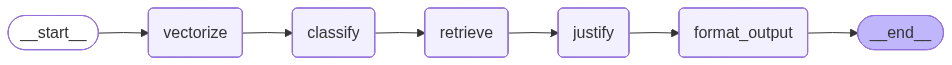

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import draw_mermaid_png
from classifier.graph import GraphRuntime, build_eval_graph
from classifier.justifiers import LinearJustifier

# Gerar diagrama do grafo LangGraph (inferência)
graph_runtime = GraphRuntime(
    classifier=ml_classifier,
    justifier=LinearJustifier(
        ml_classifier.classifier.coef_,
        ml_classifier.classifier.classes_,
        ml_classifier.features,
    ),
    justification_mode="linear",
    retriever=None,
    k_similar=K_SIMILAR,
)
graph = build_eval_graph(graph_runtime)
try:
    mermaid_syntax = graph.get_graph().draw_mermaid()
    mermaid_syntax = mermaid_syntax.replace("graph TD;", "graph LR;")
    png_bytes = draw_mermaid_png(mermaid_syntax=mermaid_syntax)
    display(Image(png_bytes))
except Exception as exc:
    print(f"Falha ao renderizar grafo: {exc}")


In [15]:
import plotly.graph_objects as go

# Criar diagrama de arquitetura
fig = go.Figure()

# Etapas detalhadas do pipeline
steps = [
    ("Ticket", "#e1f5fe", "Texto de entrada"),
    ("TF-IDF", "#e8eaf6", "Vetorizacao\nTF-IDF"),
    ("LinearSVC", "#ede7f6", "Classificacao\nSupervisionada"),
    ("Retrieval", "#e8f5e9", "K similares\n(evidencia, apenas LLM)"),
    ("Justifier", "#f3e5f5", "Linear (padrao) ou\nLLM (opcional)"),
    ("Output", "#e0f2f1", "{\"classe\": \"...\", \"justificativa\": \"...\"}"),
]

# Posições
x_positions = list(range(len(steps)))
y_pos = 0.5

# Adicionar caixas e textos
for i, (name, color, desc) in enumerate(steps):
    # Caixa
    fig.add_shape(
        type="rect",
        x0=i - 0.4, x1=i + 0.4,
        y0=0.2, y1=0.8,
        fillcolor=color,
        line=dict(color="#333", width=2),
    )
    # Nome da etapa
    fig.add_annotation(
        x=i, y=0.65,
        text=f"<b>{name}</b>",
        showarrow=False,
        font=dict(size=14),
    )
    # Descrição
    fig.add_annotation(
        x=i, y=0.38,
        text=desc,
        showarrow=False,
        font=dict(size=10),
        align="center",
    )
    # Seta para próxima etapa
    if i < len(steps) - 1:
        fig.add_annotation(
            x=i + 0.5, y=0.5,
            ax=i + 0.42, ay=0.5,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowcolor="#333",
        )

# Super nós (caixas maiores com borda pontilhada)
# Classificacao: TF-IDF + LinearSVC (indices 1 e 2)
fig.add_shape(
    type="rect",
    x0=1 - 0.45, x1=2 + 0.45,
    y0=0.05, y1=0.95,
    fillcolor="rgba(0,0,0,0)",
    line=dict(color="#555", width=2, dash="dot"),
)
fig.add_annotation(
    x=1.5, y=0.92,
    text="<b>Classificacao</b>",
    showarrow=False,
    font=dict(size=12, color="#333"),
)

# Justificacao: Retrieval + Justifier (indices 3 e 4)
fig.add_shape(
    type="rect",
    x0=3 - 0.45, x1=4 + 0.45,
    y0=0.05, y1=0.95,
    fillcolor="rgba(0,0,0,0)",
    line=dict(color="#555", width=2, dash="dot"),
)
fig.add_annotation(
    x=3.5, y=0.92,
    text="<b>Justificacao</b>",
    showarrow=False,
    font=dict(size=12, color="#333"),
)

fig.update_layout(
    title=dict(text="Arquitetura do Pipeline", x=0.5, font=dict(size=16)),
    xaxis=dict(visible=False, range=[-0.6, len(steps) - 0.4]),
    yaxis=dict(visible=False, range=[0, 1]),
    height=300,
    margin=dict(l=20, r=20, t=50, b=20),
    plot_bgcolor="white",
)

fig.show()


#### Classificação


In [16]:
from classifier.config import JUSTIFICATION, K_SIMILAR, REASONING_EFFORT
from classifier.justifiers import LinearJustifier, LlmJustifier
from classifier.llm import LlmClient
from classifier.rag import TicketRetriever

# Pipeline sequencial (classificacao + justificativa)
justification_mode = JUSTIFICATION
justifier = None

if justification_mode == "llm":
    try:
        retriever = TicketRetriever()
        retriever.index(train_df)
        llm_client = LlmClient()
        justifier = LlmJustifier(
            llm_client,
            retriever,
            k_similar=K_SIMILAR,
            reasoning_effort=REASONING_EFFORT,
        )
    except Exception as exc:
        print(f"Falha ao configurar LLM ({exc}); usando justificativa linear.")
        justification_mode = "linear"

if justification_mode == "linear":
    justifier = LinearJustifier(
        ml_classifier.classifier.coef_,
        ml_classifier.classifier.classes_,
        ml_classifier.features,
    )

def run_pipeline(ticket: str):
    predicted_class = ml_classifier.predict([ticket])[0]
    return justifier.justify(ticket=ticket, predicted_class=predicted_class)


Batches:   0%|          | 0/1191 [00:00<?, ?it/s]

In [17]:
# Gerar justificativa usando o pipeline completo
details = run_pipeline(ticket=query)

print(f'Classe real: {true_class}')
print(f'Classe predita (ML): {details.predicted_class}')
print(f'Justificativa: {details.result.justificativa}')
if details.reasoning:
    print('\nReasoning:')
    print(details.reasoning)
print(f'\nCorreto: {details.predicted_class == true_class}')


Classe real: HR Support
Classe predita (ML): HR Support
Justificativa: O ticket envolve uma solicitação para atualizar ou cancelar um feriado em julho, mencionando 'annual leave balance' e 'holiday', o que é típico de questões de gerenciamento de férias tratadas pelo suporte de RH.

Reasoning:
First, the user asks me to generate a justification for the given classification. The class assigned is "HR Support". I need to respond only with JSON in the format: {"justificativa": "<explicação curta e objetiva de 1-3 frases>"}. The justification must be in Portuguese (Brazil), short and objective, 1-3 sentences.

The ticket provided is: "annual leave balance thursday pm annual leave balance hi please think update holiday st july cancelled thanks coordinator ext"

I need to use evidence from the ticket and the provided similar tickets to support the class. However, I must not mention similar tickets explicitly (e.g., "ticket 2"). I should only use general evidence from the ticket content.

The

## 5. Avaliação do Classificador

Avaliamos o desempenho do classificador escolhido (**TF-IDF + LinearSVC**) no conjunto de **validação balanceado**
(200 tickets, 25 por classe).

### Métricas utilizadas

- **Accuracy:** proporção de classificações corretas
- **F1 Macro:** média não-ponderada do F1 por classe (trata todas as classes igualmente)
- **Cohen's Kappa:** concordância além do acaso
- **MCC (Matthews Correlation Coefficient):** métrica robusta para classificação multiclasse
- **Confusion Matrix:** visualiza erros de classificação entre classes

### Observação

Nesta seção avaliamos **apenas a classificação** (sem gerar justificativas) para manter a execução rápida e independente de LLM.


In [18]:
from classifier.metrics import evaluate, print_report, plot_confusion_matrix, plot_per_class_metrics
from classifier.runner import classify_batch_no_justification
from classifier.classifiers import TfidfClassifier
from classifier.config import RANDOM_STATE

In [19]:
# Treinar o classificador escolhido (TF-IDF + LinearSVC)
ml_classifier = TfidfClassifier.linear_svc(random_state=RANDOM_STATE)
ml_classifier.fit(train_df)

# Classificar tickets (sem justificativas)
results, classification_errors = classify_batch_no_justification(
    test_df=validation_df,
    classifier=ml_classifier,
    show_progress=True,
)

# Extrair y_true e y_pred para métricas
y_true = [r["true_class"] for r in results]
y_pred = [r["predicted_class"] for r in results]

print(f"\nClassificação concluída!")
print(f"Classificados com sucesso: {len(results)}")
if classification_errors:
    print(f"Erros: {len(classification_errors)}")

Classifying: 100%|██████████| 200/200 [00:00<00:00, 4804.66it/s, ok=1, pred=Storage]  


Classificação concluída!
Classificados com sucesso: 200


In [20]:
# Calcular métricas
metrics = evaluate(y_true, y_pred, classes)
print_report(metrics, classes)

RELATÓRIO DE AVALIAÇÃO

Accuracy:      0.8500
F1 Macro:      0.8527
F1 Weighted:   0.8527
Cohen's Kappa: 0.8286
MCC:           0.8309

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Access       0.86      0.96      0.91        25
Administrative rights       0.95      0.72      0.82        25
           HR Support       0.70      0.92      0.79        25
             Hardware       0.69      0.88      0.77        25
     Internal Project       0.95      0.84      0.89        25
        Miscellaneous       0.91      0.80      0.85        25
             Purchase       1.00      0.84      0.91        25
              Storage       0.91      0.84      0.88        25

             accuracy                           0.85       200
            macro avg       0.87      0.85      0.85       200
         weighted avg    

### Interpretação das Métricas Gerais

Os resultados no conjunto de validação indicam um classificador com **boa performance**:

| Métrica | Valor | Interpretação |
|---------|-------|---------------|
| **Accuracy** | **85.0%** | 170/200 tickets classificados corretamente |
| **F1 Macro** | **85.27%** | performance equilibrada entre as classes |
| **Cohen's Kappa** | **0.829** | concordância **alta** além do acaso |
| **MCC** | **0.831** | métrica robusta e consistente para multiclasse |

**Destaques por classe:**
- **Access:** recall **0.96** e F1 **0.91** (classe bem separada)
- **Internal Project:** precision **0.95** e F1 **0.89**
- **Purchase:** precision **1.00** e F1 **0.91**

**Pontos de atenção:**
- **Administrative rights** é a classe mais difícil (F1 **0.82**, recall **0.72**) — muitos tickets “vazam” para classes próximas
- **HR Support** tem recall alto (**0.92**), mas precision menor (**0.70**) — tende a absorver falsos positivos


### Métricas por Classe

O gráfico abaixo mostra precision, recall e F1-score para cada classe, facilitando a identificação visual de quais classes têm melhor/pior desempenho.

In [21]:
# Gráfico de métricas por classe
plot_per_class_metrics(y_true, y_pred, classes, title="Precision, Recall e F1-Score por Classe")

In [22]:
# Visualizar confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"], classes, title="Confusion Matrix - TF-IDF + LinearSVC")

### Desbalanceamento do Dataset vs Erros de Classificação

No `notebooks/analysis.ipynb`, observamos que o `dataset.csv` é **fortemente desbalanceado** (ex.: *Hardware* e *HR Support* somam > 50% dos tickets).

Mesmo avaliando em um conjunto de **validação balanceado** (25 por classe), o classificador é **treinado** com o conjunto **desbalanceado** — o que pode induzir:

- **Viés de predição**: mais tickets sendo classificados nas classes mais frequentes do treino.
- **Assinatura clássica de desbalanceamento**:
  - classes frequentes tendem a ter **recall maior** (mais fáceis de “capturar”),
  - mas também podem atrair **mais falsos positivos** (precision menor),
  - enquanto classes raras sofrem com **falsos negativos** (recall menor).

Os gráficos abaixo quantificam essa relação usando apenas variáveis já calculadas neste notebook:
- **frequência por classe** em `train_df` (distribuição que influencia o treino)
- **erros e métricas** em `results`, `y_true`, `y_pred` e `metrics`


In [23]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Usa apenas variaveis ja existentes no notebook:
# - df / train_df / validation_df
# - results, y_true, y_pred, metrics, classes
classes_out = classes

# Frequencia no dataset completo e no conjunto de treino (o que o modelo realmente ve)
dataset_counts_full = (
    df["Topic_group"]
    .value_counts()
    .reindex(classes_out)
    .rename_axis("Classe")
    .reset_index(name="Qtde")
)

dataset_counts_full["%"] = dataset_counts_full["Qtde"] / dataset_counts_full["Qtde"].sum()

train_counts = (
    train_df["Topic_group"]
    .value_counts()
    .reindex(classes_out)
    .rename_axis("Classe")
    .reset_index(name="Qtde_treino")
)

train_counts["%_treino"] = train_counts["Qtde_treino"] / train_counts["Qtde_treino"].sum()

dataset_counts = dataset_counts_full.merge(train_counts, on="Classe", how="left")

per_class_df = (
    pd.DataFrame.from_dict(metrics["per_class"], orient="index")
    .reset_index()
    .rename(columns={"index": "Classe"})
    .merge(dataset_counts[["Classe", "Qtde_treino", "%_treino"]], on="Classe", how="left")
)

cls_df = pd.DataFrame(results)
errors_df = cls_df[cls_df["true_class"] != cls_df["predicted_class"]]

pred_counts = pd.Series(y_pred).value_counts().reindex(classes_out, fill_value=0)
expected_per_class = int(len(validation_df) / len(classes_out))

err_by_true = errors_df["true_class"].value_counts().reindex(classes_out, fill_value=0)
err_by_pred = errors_df["predicted_class"].value_counts().reindex(classes_out, fill_value=0)

tp = (cls_df["true_class"] == cls_df["predicted_class"]).groupby(cls_df["true_class"]).sum().reindex(classes_out, fill_value=0)
fn = err_by_true
fp = err_by_pred

err_table = pd.DataFrame({
    "Classe": classes_out,
    "Qtde_treino": dataset_counts.set_index("Classe")["Qtde_treino"].reindex(classes_out).values,
    "TP": tp.values,
    "FN": fn.values,
    "FP": fp.values,
})

err_table = err_table.merge(per_class_df[["Classe", "precision", "recall", "f1"]], on="Classe", how="left")

print("Dataset (frequencia no TREINO; top/bottom):")
print(dataset_counts.sort_values("Qtde_treino", ascending=False).head(3)[["Classe", "Qtde_treino", "%_treino"]].to_string(index=False))
print(dataset_counts.sort_values("Qtde_treino", ascending=True).head(3)[["Classe", "Qtde_treino", "%_treino"]].to_string(index=False))

print("\nVies na validacao (predito vs esperado=25 por classe):")
print(pd.DataFrame({"Preditos": pred_counts, "Delta": pred_counts - expected_per_class}).to_string())

print("\nErros por classe (validacao):")
print(err_table[["Classe", "Qtde_treino", "precision", "recall", "TP", "FN", "FP"]].sort_values("Qtde_treino").to_string(index=False))

# --- Grafico 1: distribuicao no treino (desbalanceamento relevante)
fig1 = px.bar(
    dataset_counts.sort_values("Qtde_treino", ascending=True),
    x="Qtde_treino",
    y="Classe",
    orientation="h",
    text=dataset_counts.sort_values("Qtde_treino", ascending=True)["%_treino"].map(lambda x: f"{x:.1%}"),
    title="Distribuicao de classes no TREINO (desbalanceamento que influencia o modelo)",
)
fig1.update_traces(textposition="outside", cliponaxis=False)
fig1.update_layout(height=380, xaxis_title="Quantidade (train_df)", yaxis_title="")
fig1.show()

# --- Grafico 2: frequencia (treino) vs (precision/recall) na validacao
fig2 = make_subplots(rows=1, cols=2, subplot_titles=("Frequencia (treino) vs Recall", "Frequencia (treino) vs Precision"))

fig2.add_trace(
    go.Scatter(
        x=per_class_df["Qtde_treino"],
        y=per_class_df["recall"],
        mode="markers+text",
        text=per_class_df["Classe"],
        textposition="top center",
        marker=dict(size=10),
        name="Recall",
    ),
    row=1,
    col=1,
)
fig2.add_trace(
    go.Scatter(
        x=per_class_df["Qtde_treino"],
        y=per_class_df["precision"],
        mode="markers+text",
        text=per_class_df["Classe"],
        textposition="top center",
        marker=dict(size=10),
        name="Precision",
    ),
    row=1,
    col=2,
)
fig2.update_xaxes(type="log", title_text="Qtde no treino (escala log)", row=1, col=1)
fig2.update_xaxes(type="log", title_text="Qtde no treino (escala log)", row=1, col=2)
fig2.update_yaxes(range=[0, 1.05], title_text="Recall", row=1, col=1)
fig2.update_yaxes(range=[0, 1.05], title_text="Precision", row=1, col=2)
fig2.update_layout(height=380, title_text="Relacao entre desbalanceamento (treino) e metricas por classe (validacao)")
fig2.show()

# --- Grafico 3: vies de predicao na validacao (predito vs esperado)
pred_dist = pred_counts.rename_axis("Classe").reset_index(name="Preditos")
fig3 = px.bar(
    pred_dist,
    x="Preditos",
    y="Classe",
    orientation="h",
    title="Distribuicao das classes preditas na validacao (viés para classes frequentes)",
)
fig3.add_vline(
    x=expected_per_class,
    line_dash="dash",
    line_color="black",
    annotation_text=f"Esperado ({expected_per_class} por classe)",
    annotation_position="top right",
)
fig3.update_layout(height=380, xaxis_title="Quantidade predita (validacao)", yaxis_title="")
fig3.show()

# --- Grafico 4: FN/FP por classe (visao direta dos erros)
err_plot = err_table[["Classe", "FN", "FP"]].melt(id_vars=["Classe"], var_name="Tipo", value_name="Qtde")
fig4 = px.bar(
    err_plot,
    x="Qtde",
    y="Classe",
    color="Tipo",
    barmode="group",
    orientation="h",
    title="Erros por classe na validacao (FN por classe real, FP por classe predita)",
)
fig4.update_layout(height=380, xaxis_title="Quantidade", yaxis_title="")
fig4.show()

# Correlacao simples (indicativa; apenas 8 classes)
per_class_df["log10_qtde_treino"] = np.log10(per_class_df["Qtde_treino"].replace(0, np.nan))
print("\nCorrelacoes (indicativas; n=8 classes):")
print("corr(log10(freq_treino), recall)=", round(per_class_df[["log10_qtde_treino", "recall"]].corr().iloc[0, 1], 3))
print("corr(log10(freq_treino), precision)=", round(per_class_df[["log10_qtde_treino", "precision"]].corr().iloc[0, 1], 3))


Dataset (frequencia no TREINO; top/bottom):
    Classe  Qtde_treino  %_treino
  Hardware        10873  0.285313
HR Support         8712  0.228607
    Access         5680  0.149046
               Classe  Qtde_treino  %_treino
Administrative rights         1388  0.036422
     Internal Project         1675  0.043953
             Purchase         1951  0.051195

Vies na validacao (predito vs esperado=25 por classe):
                       Preditos  Delta
Access                       28      3
Administrative rights        19     -6
HR Support                   33      8
Hardware                     32      7
Internal Project             22     -3
Miscellaneous                22     -3
Purchase                     21     -4
Storage                      23     -2

Erros por classe (validacao):
               Classe  Qtde_treino  precision  recall  TP  FN  FP
Administrative rights         1388   0.947368    0.72  18   7   1
     Internal Project         1675   0.954545    0.84  21   4   1
    


Correlacoes (indicativas; n=8 classes):
corr(log10(freq_treino), recall)= 0.644
corr(log10(freq_treino), precision)= -0.88


#### Discussao dos Resultados

Com base nos graficos e tabelas acima, aparecem tres sinais consistentes de que o **desbalanceamento do treino** esta relacionado aos erros:

- **Vies de predicao na validacao:** mesmo com validacao balanceada (25 por classe), a distribuicao em `y_pred` tende a **superestimar classes mais frequentes** no `train_df` (veja a tabela *Delta* e o grafico de distribuicao das classes preditas).
- **Recall vs frequencia:** classes com mais exemplos no treino tendem a ter **recall maior**; ja classes com poucos exemplos (ex.: *Administrative rights*) acumulam mais **FN**, reduzindo o recall.
- **Precision em classes dominantes:** classes muito frequentes (ex.: *Hardware*, *HR Support*) podem atrair mais **FP** (muitos textos ambiguos acabam caindo nelas), o que puxa a precision para baixo, mesmo com recall alto.

### Análise da Matriz de Confusão

A matriz de confusão normalizada ajuda a entender **quais classes se confundem**.

**Principais confusões (real → predito):**

| Confusão | Ocorrências | Observação |
|----------|-------------|------------|
| Administrative rights → Hardware | 4 | termos de “problema no PC” e manutenção aparecem sem indicar permissão |
| Internal Project → HR Support | 3 | pedidos de suporte interno pouco específicos |
| Storage → Access | 3 | menções a “acesso/permission” em tickets de storage |
| HR Support → Hardware | 2 | descrição vaga vira suporte técnico geral |
| Miscellaneous → HR Support | 2 | tickets genéricos acabam indo para HR Support |
| Miscellaneous → Hardware | 2 | sintomas técnicos vagos puxam para Hardware |

**Leitura rápida:**
- O gargalo principal segue sendo **Administrative rights** (recall **0.72**).
- **HR Support** continua como “classe absorvedora” (recall alto, precision menor), consistente com as confusões acima.


### Confusion Matrix Normalizada

A versão normalizada mostra percentagens em vez de contagens absolutas, facilitando a identificação de taxas de erro por classe.

In [24]:
# Confusion matrix normalizada (percentagens)
plot_confusion_matrix(
    metrics["confusion_matrix"], 
    classes, 
    title="Confusion Matrix - Normalizada por True Label",
    normalize=True
)

### Análise de Erros

Nesta seção analisamos os **erros de classificação (ML)** — casos em que a classe predita pelo **TF-IDF + LinearSVC** difere da classe real.


In [25]:
# Filtrar erros
errors = [r for r in results if not r["correct"]]
print(f"Total de erros: {len(errors)} de {len(results)} ({100 * len(errors) / len(results):.1f}%)\n")

# Mostrar alguns exemplos de erros
print("=" * 80)
print("EXEMPLOS DE ERROS DE CLASSIFICAÇÃO")
print("=" * 80)

for i, error in enumerate(errors[:5], 1):
    print(f"\n--- Erro {i} ---")
    print(f"Classe real:     {error['true_class']}")
    print(f"Classe predita:  {error['predicted_class']}")
    if error.get("justification"):
        print(f"Justificativa:   {error['justification']}")
    print(f"Ticket:          {error['ticket'][:200]}...")

Total de erros: 30 de 200 (15.0%)

EXEMPLOS DE ERROS DE CLASSIFICAÇÃO

--- Erro 1 ---
Classe real:     Access
Classe predita:  HR Support
Ticket:          access for july pm re needed hi forgot specify confluence base thank kind regards wednesday july pm needed hello please thank kind regards analyst...

--- Erro 2 ---
Classe real:     Administrative rights
Classe predita:  HR Support
Ticket:          set up two xerox printers to scan and set up two xerox printers...

--- Erro 3 ---
Classe real:     Administrative rights
Classe predita:  Storage
Ticket:          unable to re install some applications dearest have unusual problem xmas gift for you unable re install some applications be related icon images desktop disappeared trying re install reader error temp...

--- Erro 4 ---
Classe real:     Administrative rights
Classe predita:  Hardware
Ticket:          virus or virus hi please attached thanks virus sh location lead...

--- Erro 5 ---
Classe real:     Administrative rights
Classe 

### Padrões nos Erros de Classificação

Com **30 erros (15.0%)** no total, os padrões mais recorrentes foram:

**1) Administrative rights → Hardware (4 erros)**
É a classe mais difícil (recall 0.72). Muitos tickets descrevem “problema no computador” ou “preciso de ajuda”,
sem explicitar que o problema é **permissão**/direito administrativo.

**2) Internal Project → HR Support (3 erros)** e **Storage → Access (3 erros)**
Pedidos internos pouco específicos caem em HR Support; tickets de storage mencionam “acesso/permission” e puxam para Access.

**3) Outras confusões menores (2 ocorrências)**
- HR Support → Hardware
- Miscellaneous → HR Support
- Miscellaneous → Hardware

**Insight:**
Boa parte dos erros acontece em zonas onde o texto do ticket é **curto** ou **genérico** e não traz termos distintivos.
Nesses casos, tanto o classificador quanto a recuperação de evidências tendem a oscilar para classes mais “amplas”.


In [26]:
# Distribuição de erros por classe
from collections import Counter

print("Distribuição de erros por classe real:")
error_by_true = Counter(e["true_class"] for e in errors)
for cls, count in sorted(error_by_true.items(), key=lambda x: -x[1]):
    print(f"  {cls}: {count} erros")

print("\nConfusões mais comuns (real → predito):")
confusion_pairs = Counter((e["true_class"], e["predicted_class"]) for e in errors)
for (true, pred), count in confusion_pairs.most_common(10):
    print(f"  {true} → {pred}: {count}x")

Distribuição de erros por classe real:
  Administrative rights: 7 erros
  Miscellaneous: 5 erros
  Internal Project: 4 erros
  Purchase: 4 erros
  Storage: 4 erros
  Hardware: 3 erros
  HR Support: 2 erros
  Access: 1 erros

Confusões mais comuns (real → predito):
  Administrative rights → Hardware: 4x
  Internal Project → HR Support: 3x
  Storage → Access: 3x
  HR Support → Hardware: 2x
  Miscellaneous → HR Support: 2x
  Miscellaneous → Hardware: 2x
  Access → HR Support: 1x
  Administrative rights → HR Support: 1x
  Administrative rights → Storage: 1x
  Administrative rights → Access: 1x


### Similaridade do Contexto Recuperado (RAG) e Dificuldade do Ticket

Embora a **classificação** seja feita pelo modelo **TF-IDF + LinearSVC**, ainda usamos embeddings para recuperar
K tickets similares que servem como **evidência** na justificativa.

Abaixo, comparamos o score médio de similaridade dos tickets recuperados para exemplos **corretos** vs **incorretos**:

| Predições | Similaridade Média | Similaridade Mediana |
|-----------|-------------------|---------------------|
| **Corretas** | 0.763 | 0.758 |
| **Incorretas** | 0.647 | 0.649 |

**Interpretação:** tickets que o classificador erra tendem, em média, a ter **evidências menos próximas** no espaço de embeddings.
Isso é um sinal de que eles são menos “típicos”/mais ambíguos no dataset, o que pode afetar tanto a classificação quanto
a qualidade da justificativa baseada em evidência.

### Distribuição de Erros por Classe

Visualização gráfica dos erros por classe real, facilitando a identificação de quais classes são mais difíceis de classificar corretamente.

In [27]:
import plotly.express as px

# Gráfico de erros por classe
if errors:
    error_data = [{"Classe": cls, "Erros": count} for cls, count in error_by_true.items()]
    fig = px.bar(
        error_data, 
        x="Erros", 
        y="Classe", 
        orientation="h",
        title="Erros por Classe Real",
        color="Erros",
        color_continuous_scale="Reds"
    )
    fig.update_layout(height=350, showlegend=False)
    fig.show()
else:
    print("Nenhum erro de classificação para exibir!")

### Similaridade por Classe: Predições Erradas vs Corretas

Comparamos a distribuição de similaridade para:
- **predições erradas**: classe predita vs classe real
- **predições corretas**: classe real

Isso mostra se, no espaço de embeddings, os erros tendem a ter baixa similaridade com a classe real e, em vários casos,
maior proximidade com a classe predita, enquanto os acertos mantêm similaridade mais alta com a classe correta.


In [28]:
import pandas as pd

# Análise de similaridade por classe para predições erradas e corretas
if errors:
    # Para cada erro, calcular similaridade com classe predita e classe real
    similarity_data = []

    for error in errors:
        ticket_text = error['ticket']
        pred_class = error['predicted_class']
        true_class = error['true_class']

        # Similaridade com classe predita
        pred_sim = retriever.compute_class_similarity(ticket_text, pred_class, k=5)
        # Similaridade com classe real
        true_sim = retriever.compute_class_similarity(ticket_text, true_class, k=5)

        similarity_data.append({
            'ticket': ticket_text[:100] + '...',
            'pred_class': pred_class,
            'true_class': true_class,
            'similarity_pred': pred_sim['mean_score'],
            'similarity_true': true_sim['mean_score'],
            'difference': pred_sim['mean_score'] - true_sim['mean_score'],
        })

    sim_df = pd.DataFrame(similarity_data)

    # Predições corretas: similaridade com a classe real
    correct = [r for r in results if r['predicted_class'] == r['true_class']]
    correct_scores = []
    for item in correct:
        ticket_text = item['ticket']
        true_class = item['true_class']
        true_sim = retriever.compute_class_similarity(ticket_text, true_class, k=5)
        correct_scores.append(true_sim['mean_score'])

    # Visualização: Box plot comparando as similaridades
    fig = go.Figure()
    fig.add_trace(go.Box(
        y=sim_df['similarity_pred'],
        name='Erradas: Classe Predita',
        marker_color='#d62728'
    ))
    fig.add_trace(go.Box(
        y=sim_df['similarity_true'],
        name='Erradas: Classe Real',
        marker_color='#2ca02c'
    ))
    fig.add_trace(go.Box(
        y=correct_scores,
        name='Corretas: Classe Real',
        marker_color='#1f77b4'
    ))

    fig.update_layout(
        title='Similaridade por Classe: Predições Erradas vs Corretas',
        yaxis_title='Score de Similaridade (média top-K)',
        height=400
    )
    fig.show()

    # Estatísticas
    print(f"Similaridade com classe predita (erros): média={sim_df['similarity_pred'].mean():.3f}, "
          f"mediana={sim_df['similarity_pred'].median():.3f}")
    print(f"Similaridade com classe real (erros):   média={sim_df['similarity_true'].mean():.3f}, "
          f"mediana={sim_df['similarity_true'].median():.3f}")
    if correct_scores:
        correct_series = pd.Series(correct_scores)
        print(f"Similaridade com classe real (corretas): média={correct_series.mean():.3f}, "
              f"mediana={correct_series.median():.3f}")

    # Análise: Quantos erros têm maior similaridade com a predita?
    higher_pred_sim = (sim_df['similarity_pred'] > sim_df['similarity_true']).sum()
    print("")
    print(f"Erros com maior similaridade à classe predita: {higher_pred_sim}/{len(errors)} "
          f"({100*higher_pred_sim/len(errors):.1f}%)")
else:
    print("Nenhum erro de classificação para análise de similaridade.")


Similaridade com classe predita (erros): média=0.623, mediana=0.641
Similaridade com classe real (erros):   média=0.600, mediana=0.604
Similaridade com classe real (corretas): média=0.749, mediana=0.750

Erros com maior similaridade à classe predita: 16/30 (53.3%)


Em grande parte dos erros, o nível de confiança é baixo: a similaridade média com a classe predita tende a ser baixa (média de 0.623), enquanto as predições corretas têm uma similaridade média maior (média de 0.749); e muitas vezes a similaridade com a classe predita é maior do que com a classe real. Isso indica que o erro não é aleatório, mas coerente com a vizinhança semântica do ticket, sugerindo ambiguidade do texto ou sobreposição lexical entre classes.

## 6. Síntese dos Resultados com LLM (opcional)

Opcionalmente, podemos usar uma LLM para sintetizar os resultados desta execução em um texto técnico.
Essa etapa **não participa da classificação**: ela apenas resume métricas, padrões de erro e trade-offs.

Ela recebe:
- métricas globais e por classe
- matriz de confusão e principais confusões
- amostras de erros (até 20), com justificativa e tickets similares recuperados como evidência
- configuração da execução (k, modelos e random_state)

A seguir, geramos a síntese com os dados desta execução.


In [29]:
from classifier.conclusion import (
    build_conclusion_payload,
    build_conclusion_system_prompt,
    build_conclusion_user_prompt,
)
from classifier.config import EMBEDDING_MODEL, K_SIMILAR, RANDOM_STATE
from classifier.llm import ConclusionError, LlmClient

llm_client = None
llm_model = None
try:
    llm_client = LlmClient()
    llm_model = llm_client.model
except ValueError:
    print("LLM não configurada; pulando geração da conclusão.")

payload = build_conclusion_payload(
    dataset="dataset.csv",
    classes=classes,
    test_size=len(validation_df),
    k_similar=K_SIMILAR,
    embedding_model=EMBEDDING_MODEL,
    llm_model=llm_model,
    random_state=RANDOM_STATE,
    classifications=results,
    errors=classification_errors,
    metrics=metrics,
    token_usage=globals().get("total_tokens"),
    max_misclassified=20,
)

if llm_client:
    system_prompt = build_conclusion_system_prompt()
    user_prompt = build_conclusion_user_prompt(payload)

    try:
        conclusion_text, conclusion_usage = llm_client.generate_conclusion(
            system_prompt=system_prompt,
            user_prompt=user_prompt,
        )
        print(conclusion_text)
        print(f"\nTokens usados (conclusão): {conclusion_usage.total_tokens:,}")
    except ConclusionError as exc:
        print(f"Falha ao gerar conclusão: {exc}")


**Resumo**
O classificador atingiu 85% de acurácia, com métricas macro e weighted F1 idênticas (0.8527), indicando desempenho equilibrado entre classes. O Cohen Kappa (0.8286) e MCC (0.8309) confirmam uma boa concordência acima do acaso, sugerindo generalização consistente. No entanto, a análise detalhada revela vulnerabilidades em classes específicas e padrões de confusão recorrentes.

**Métricas Globais**
A acurácia de 0.85 é sólida, mas a igualdade entre F1 macro e weighted (0.8527) indica que o desempenho não é drasticamente afetado por classes majoritárias. O Cohen Kappa (0.8286) e MCC (0.8309) são altos, validando a robustez do modelo. A ausência de `token_usage` (todos zero) sugere que o RAG não foi invocado ou não consumiu recursos, o que é um ponto crítico para investigar.

**Por Classe**
*   **Melhor desempenho:** `Purchase` (F1=0.9130, precision=1.0) e `Access` (F1=0.9057, recall=0.96). `Purchase` tem precisão perfeita, mas recall de 0.84, indicando que alguns tickets não sã

## 7. Considerações Finais

- O classificador **TF-IDF (word-only) + LinearSVC** apresentou **85% de accuracy** e **~85% de F1 macro** na validação balanceada,
  sendo uma escolha forte por combinar **boa performance** e **baixo custo/latência**.
- Para justificativas, mantemos como padrão o método **linear** (determinístico e sem dependência de LLM). Quando necessário, o modo **LLM + RAG** pode ser ativado para produzir justificativas mais naturais, ao custo de tokens/latência.
- Os principais erros concentram-se em classes semanticamente próximas (padrões de confusão), sugerindo pontos de melhoria com features e/ou ajustes no retriever.
